In [1]:
! python --version

Python 3.10.14


In [2]:
%%capture
! pip install --upgrade pip
! pip install timm
! pip install torch
! pip install pillow
! pip install ipywidgets
! pip uninstall numpy -y
! pip install "numpy<2.0"
! pip install opencv-python
! pip install scikit-learn
! pip install scipy
! pip install matplotlib
! pip install torchinfo

## Introducting PyTorch Image Modules (timm)
In this notebook, we will be using timm to pick one pre-trained vision model (ResNet 34) and create a vector embedding model from it. There is this one article on [Medium that I found very useful](https://towardsdatascience.com/getting-started-with-pytorch-image-models-timm-a-practitioners-guide-4e77b4bf9055), so I hope that this will be useful for you too.

The following are some scripts that I have used to get to know timm and ResNet 34 better.

In [3]:
import torch
import timm

pretrained_models = timm.list_models("", pretrained=True)

print(f"timm currently contains {len(pretrained_models)} pre-trained models.")

timm currently contains 1457 pre-trained models.


In [4]:
pretrained_models = timm.list_models("resnet*", pretrained=True)

print(f"timm currently contains {len(pretrained_models)} pre-trained resnet models.")

timm currently contains 117 pre-trained resnet models.


In [5]:
pretrained_models = timm.list_models("vit*", pretrained=True)

print(f"timm currently contains {len(pretrained_models)} pre-trained vision transformer models.")

timm currently contains 212 pre-trained vision transformer models.


In [6]:
resnet_model = timm.create_model("resnet34d.ra2_in1k", pretrained=True)
resnet_model.default_cfg

{'url': 'https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet34d_ra2-f8dcfcaf.pth',
 'hf_hub_id': 'timm/resnet34d.ra2_in1k',
 'architecture': 'resnet34d',
 'tag': 'ra2_in1k',
 'custom_load': False,
 'input_size': (3, 224, 224),
 'test_input_size': (3, 288, 288),
 'fixed_input_size': False,
 'interpolation': 'bicubic',
 'crop_pct': 0.875,
 'test_crop_pct': 0.95,
 'crop_mode': 'center',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'num_classes': 1000,
 'pool_size': (7, 7),
 'first_conv': 'conv1.0',
 'classifier': 'fc',
 'origin_url': 'https://github.com/huggingface/pytorch-image-models'}

In [7]:
# resnet_model.default_cfg["mean"]
type(resnet_model.default_cfg["std"])

tuple

## torchinfo summary

To get more details about a timm model, you can use the `torchinfo` library. Here is an example of how to use it.


In [8]:
from torchinfo import summary

summary(resnet_model, input_size=(1, 3, 224, 224))  # Batch size of 1

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1000]                 --
├─Sequential: 1-1                        [1, 64, 112, 112]         --
│    └─Conv2d: 2-1                       [1, 32, 112, 112]         864
│    └─BatchNorm2d: 2-2                  [1, 32, 112, 112]         64
│    └─ReLU: 2-3                         [1, 32, 112, 112]         --
│    └─Conv2d: 2-4                       [1, 32, 112, 112]         9,216
│    └─BatchNorm2d: 2-5                  [1, 32, 112, 112]         64
│    └─ReLU: 2-6                         [1, 32, 112, 112]         --
│    └─Conv2d: 2-7                       [1, 64, 112, 112]         18,432
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └

## Now let's start to build a ResNet 34 embedding model
We will be using the ResNet 34 model from timm and create a vector embedding model from it. In this notebook, we will start with a pre-trained model and then remove the last layer to get the embedding model.

In [9]:
resnet_model.reset_classifier(0)  # Remove the classification head

## Now let's use the embedding model
After removing the last layer, we will use the embedding model to get the embeddings of the images in the dataset. We will then use these embeddings to train a simple classifier to classify the images.

Let's first create a couple of helper functions to load the data and create the embedding model. The first one is to calculate the cosine similarity between two vectors. The second one generates the embeddings for an image.

In [10]:
from PIL import Image
from torchvision import transforms
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def cosine_similarity_(embedding1, embedding2):
    """
    Calculate cosine similarity between two embeddings
    """
    embedding1 = np.array(embedding1).reshape(1, -1)
    embedding2 = np.array(embedding2).reshape(1, -1)
    return cosine_similarity(embedding1, embedding2)[0][0]

def generate_embedding(image_path, model):
    """
    Generate embedding for an image
    """
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=resnet_model.default_cfg["mean"], std=resnet_model.default_cfg["std"]),
    ])
    


    image = Image.open(image_path)
    input_tensor = transform(image.convert('RGB')).unsqueeze(0)

    with torch.no_grad():
        embedding = model(input_tensor)
    
    embedding = embedding.numpy().flatten()
    # print(f'Embedding shape: {embedding.shape}')

    return embedding


## Comparing embeddings of same species


In [11]:
# similar/same birds
embedding1 = generate_embedding("../kaggle_data/bird-fifty/test/AFRICAN PYGMY GOOSE/4.jpg", resnet_model)
embedding2 = generate_embedding("../kaggle_data/bird-fifty/test/AFRICAN PYGMY GOOSE/5.jpg", resnet_model)

similarity = cosine_similarity_(embedding1, embedding2)
print(f"Cosine Similarity of is {similarity}\n")

Cosine Similarity of is 0.9535102844238281



## Comparing embeddings of different species

In [12]:
# dissimilar/different birds
embedding1 = generate_embedding("../kaggle_data/bird-fifty/test/AFRICAN PYGMY GOOSE/4.jpg", resnet_model)
embedding2 = generate_embedding("../kaggle_data/bird-fifty/test/BLUE THROATED TOUCANET/1.jpg", resnet_model)

similarity = cosine_similarity_(embedding1, embedding2)
print(f"Cosine Similarity of is {similarity}\n")

Cosine Similarity of is 0.9584269523620605



In [13]:
# dissimilar/different birds
embedding1 = generate_embedding("../kaggle_data/bird-fifty/test/CEDAR WAXWING/4.jpg", resnet_model)
embedding2 = generate_embedding("../kaggle_data/bird-fifty/test/GLOSSY IBIS/1.jpg", resnet_model)

similarity = cosine_similarity_(embedding1, embedding2)
print(f"Cosine Similarity of is {similarity}\n")

Cosine Similarity of is 0.9527592658996582



### Comments about using pre-trained model to generate embeddings

We can use a pre-trained model to generate embeddings for images. The embeddings can be used to compare images, and we can use the similarity between the embeddings to determine the species similarity (somewhat).

However if we are building a bird similarity checker, we need to be aware of the embeddings generated by the pre-trained model. The generated embeddings may not be good enough to differentiate between similar images, and sometime it just get confused by all the other species in the folder. This is because the pre-trained model was trained on a different dataset (ImageNet), and the embeddings generated by the model may not be good enough to differentiate between similar images.

In this notebook, we are using ResNet34d (resnet34d.ra2_in1k) to generate embeddings for two sets of images. If we take embeddings of the **2 images of the same species** and take the cosine similarity between them, the score reflects a very high similarity, achieving score.

However, instead if we take embeddings of the **2 images of different bird species**, the similarity is still high, but typically lower compared to one of the bird of the same species. It still works, because eventually the similarity results are sorted and the most similar images are shown first. However the similarity scores are very close together and does not reflect an embedding model that really understanda bird species.

To get better embeddings that is representative of the task at hand (bird specied similarity), we can instead fine-tune the pre-trained model against our birds species dataset, so that the vector embeddings of similar images will be closer together, while embeddings of different bird species will be further apart. This is because after fine-tuning against our dataset, the model will learn to differentiate between similar images and generate embeddings that are more representative of the dataset and task at hand.

In [19]:
# get all embeddings of images in the ../data/profiles folder
import os
import numpy as np

profiles_dir = "../kaggle_data/bird-fifty/valid/"

def get_all_embeddings(folder_path, embedding_model):
    embeddings = []
    image_paths = []
    
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file == "1.jpg":
                image_path = os.path.join(root, file)
                embedding = generate_embedding(image_path, embedding_model)
                embeddings.append(embedding)
                image_paths.append(image_path)

    return np.array(embeddings), image_paths

all_embeddings = get_all_embeddings(profiles_dir, resnet_model)

print(f"Total of {len(all_embeddings[0])} bird species.")


Total of 51 bird species.


In [20]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import numpy as np

def distance_metric(embedding1, embedding2, metric="cosine"):
  embedding1 = np.array(embedding1).reshape(1, -1)
  embedding2 = np.array(embedding2).reshape(1, -1)
  if metric == "cosine":
    return cosine_similarity(embedding1, embedding2)[0][0]
  elif metric == "euclidean":
    return euclidean_distances(embedding1, embedding2)[0][0]

def find_similarities(image_1):
    
    image_1_embedding = generate_embedding(image_1, resnet_model)

    similarities = []
    metric="cosine"
    for i, embedding in enumerate(all_embeddings[0]):
        similarity = distance_metric(image_1_embedding, embedding, metric=metric)
        similarities.append({"image_1": image_1, "image_2": all_embeddings[1][i], "similarity": similarity})

    if metric == "cosine":
        similarities = sorted(similarities, key=lambda x: x["similarity"], reverse=True)
    else:
        similarities = sorted(similarities, key=lambda x: x["similarity"])

    
    return similarities

similarities = find_similarities("../kaggle_data/bird-fifty/test/AFRICAN PYGMY GOOSE/4.jpg")

In [21]:
from matplotlib import pyplot as plt
from matplotlib import image as mp_img

def display_img(image_path, index, rows=1, columns=2, text=""):
    plt.subplot(rows, columns, index)
    img = mp_img.imread(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{image_path.split('/')[-2]}/{image_path.split('/')[-1]}")
    plt.text(0.5, -0.1, text, ha='center', transform=plt.gca().transAxes)
    
    
def display_similarities(image_1, top_k=6):
    plt.figure(figsize=(4, 5))
    
    similarities = find_similarities(image_1)
    print(f"Unknown bird species: {image_1}")
    display_img(similarities[0]["image_1"], 1, rows=1, columns=1)
    plt.show()

    plt.figure(figsize=(15, 8))
    print(f"Most simiar bird species to {image_1}.")
    for i, similarity in enumerate(similarities[:top_k]):
        display_img(similarity["image_2"], i+1, rows=2, columns=int(top_k//2), text=f"Similarity: {similarity['similarity']:.5f}")
    
    plt.show()    

Unknown bird species: unknowns/4.jpg


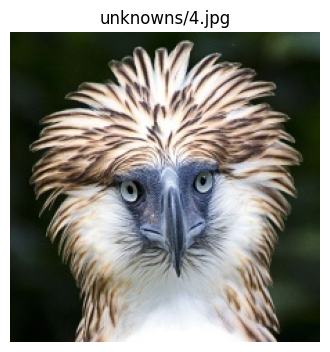

Most simiar bird species to unknowns/4.jpg.


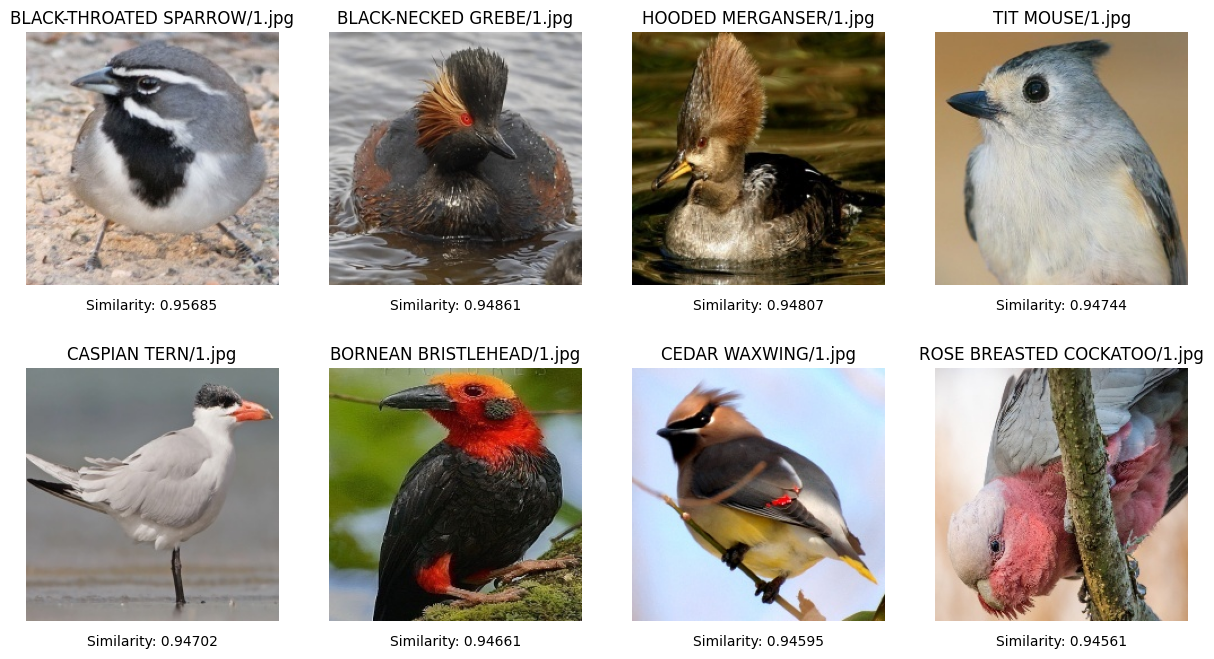

Unknown bird species: unknowns/5.jpg


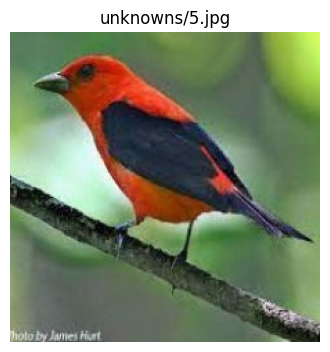

Most simiar bird species to unknowns/5.jpg.


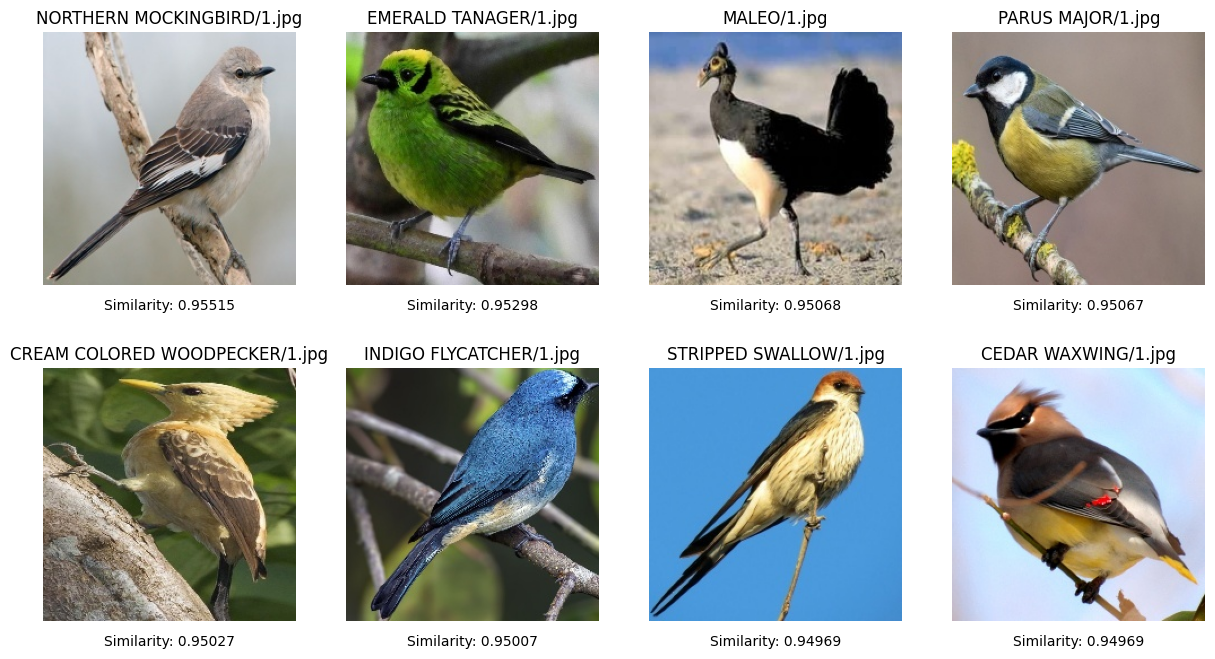

Unknown bird species: unknowns/2.jpg


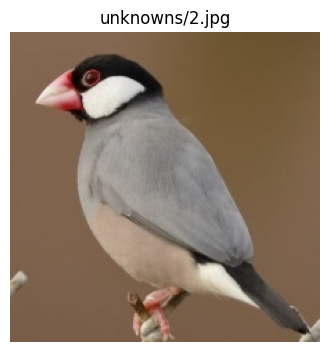

Most simiar bird species to unknowns/2.jpg.


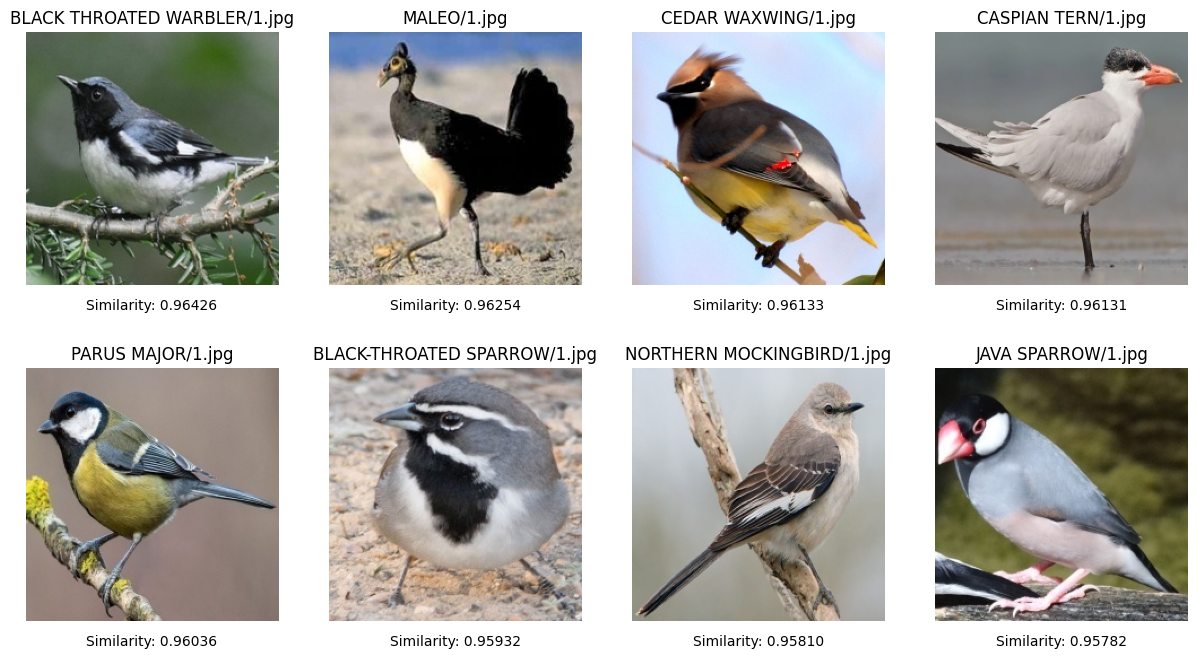

Unknown bird species: unknowns/3.jpg


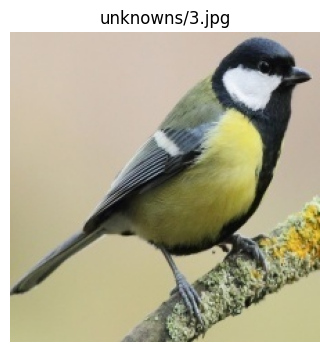

Most simiar bird species to unknowns/3.jpg.


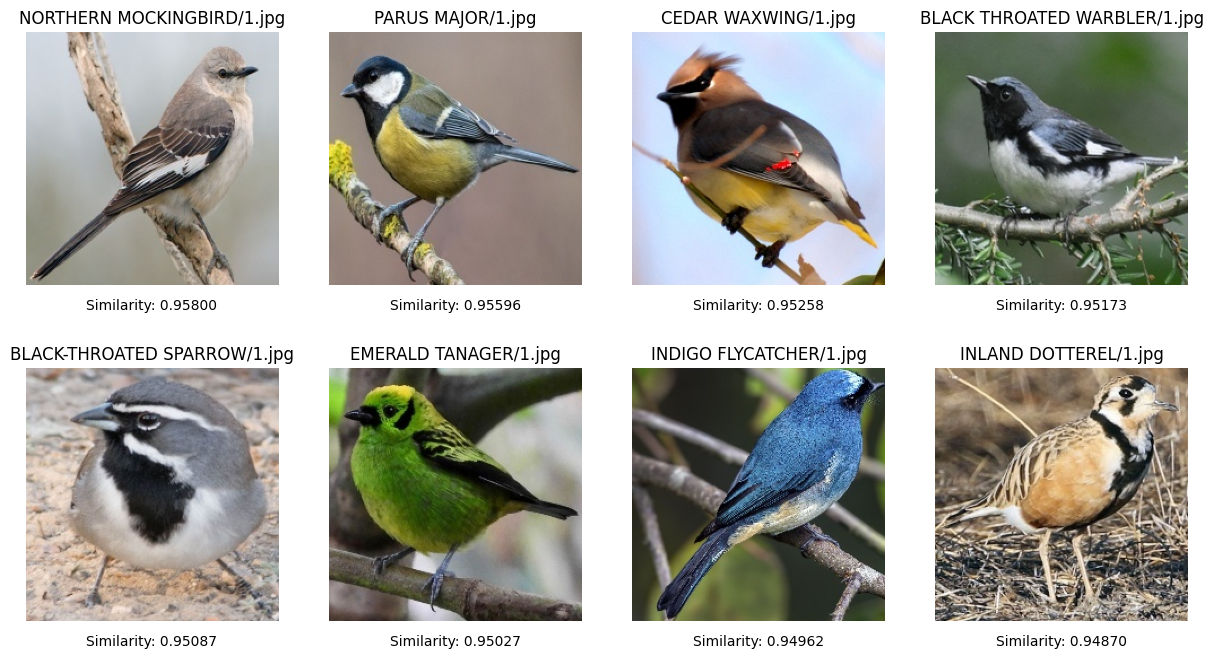

Unknown bird species: unknowns/1.jpg


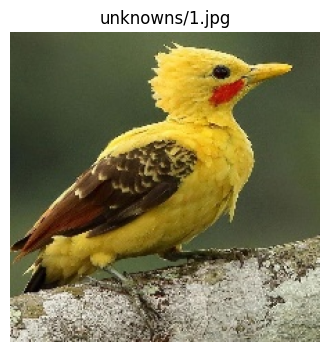

Most simiar bird species to unknowns/1.jpg.


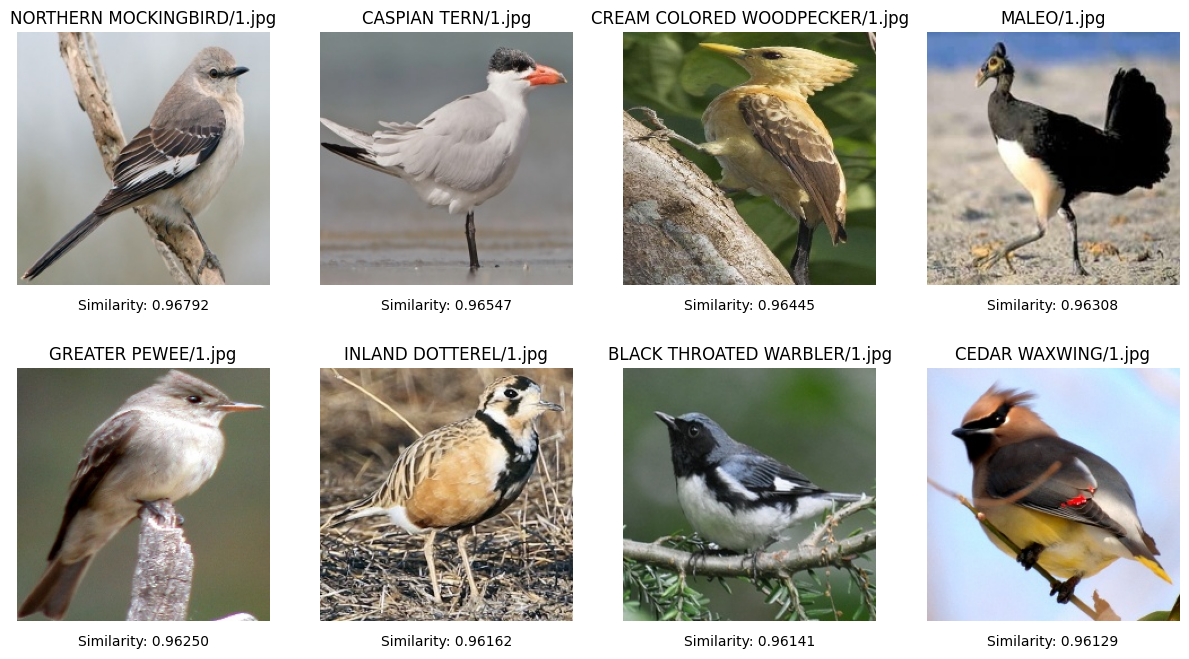

In [22]:
tracings_folder = "unknowns"

for file in os.listdir(tracings_folder):
    if file.endswith(".png") or file.endswith(".jpg"):
        display_similarities(os.path.join(tracings_folder, file), top_k=8)